### Positional Encoding and Feed-Forward Networks

### Why Positional Encoding?

- Unlike RNNs, transformers do **not** process sequences sequentially.
- Transformers process all tokens in parallel, so they lack inherent knowledge of token position.
- Knowing the position of tokens is crucial for tasks like translation, language modeling, and sequence prediction.

---

### What is Positional Encoding?

- **Positional encoding** introduces information about the order of tokens in a sequence.
- It enables the model to differentiate between identical tokens appearing in different positions.
- Without positional encoding, a transformer would treat a sentence as a bag of words, ignoring word order.

---

### Sinusoidal Positional Encoding

- Encodes positional information using sine and cosine functions of different frequencies.
- The encoding for each position is a vector, added to the input embeddings.
- **Formula for positional encoding:**

    $$
    \text{PE}_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right) \\
    \text{PE}_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
    $$

    - $pos$ is the position, $i$ is the dimension, and $d_{model}$ is the embedding size.

---

#### Why Sinusoidal Functions?

- Provides a unique encoding for each position.
- Enables the model to generalize to sequence lengths not seen during training.
- The periodic nature allows the model to easily learn to attend by relative positions.

---

### The Feed-Forward Network (FFN)

- FFNs are fully connected layers applied **independently and identically** to each token within a transformer layer.
- They add non-linear transformations to the output of the attention mechanism.

#### Role in Transformers

- Captures token-specific transformations.
- Enhances the representational capacity of the model by introducing non-linearity.

#### Structure

1. **Linear transformation** (Dense layer)
2. **Non-linear activation** (e.g., ReLU, GELU)
3. **Another linear transformation**

- Typically, the FFN expands the dimensionality (e.g., from $d_{model}$ to $4 \times d_{model}$) and then projects it back to $d_{model}$.
- Applied to each position separately and identically.

---

**Summary:**  
Positional encoding provides order information to transformers, while feed-forward networks add depth and non-linearity, enabling powerful sequence modeling without recurrence.


In [11]:
import numpy as np
import matplotlib.pyplot as plt


define positional encoding function

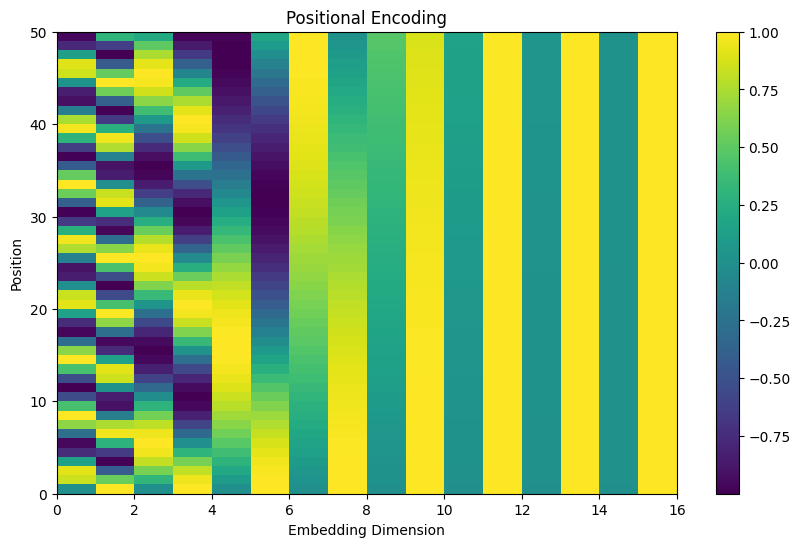

In [12]:
def positional_encoding(seq_len, embed_dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(embed_dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
    angle_rads = pos * angle_rates

    # apply sine to even indices and cosine to add indices
    pos_encoding = np.zeros(angle_rads.shape)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return pos_encoding

# generate postional encoding
seq_len = 50
embed_dim = 16
pos_encoding = positional_encoding(seq_len, embed_dim)

# visualise positional encoding
plt.figure(figsize=(10, 6))
plt.pcolormesh(pos_encoding, cmap="viridis")
plt.colorbar()
plt.title("Positional Encoding")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position")
plt.show()
    


In [ ]:
import torch
import torch.nn as nn


class TransformerWithPositionalEncoding(nn.Module):
    def __init__(self, embed_dim, seq_len, num_heads, ff_dim):
        super(TransformerWithPositionalEncoding, self).__init__()
        self.embedding = nn.Embedding(seq_len, embed_dim)
        self.positional_encoding = nn.Parameter(torch.tensor(positional_encoding(seq_len, embed_dim), dtype=torch.float32))
        self.multihhead_attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
    
    def forward(self,x):
        # add positional encoding
        x = self.embedding(x) + self.positional_encoding
        # self attention
        attn_output, _ = self.multihhead_attention(x, x, x)
        # add and norm
        x = self.norm1(x + attn_output)
        # feed forward network
        ffn_output = self.ffn(x)
        # add and norm
        x = self.norm2(x + ffn_output)
        return x
    
# define model parameters
embed_dim = 16
seq_len = 50
num_heads = 4
ff_dim = 64

model = TransformerWithPositionalEncoding(embed_dim, seq_len, num_heads, ff_dim)
print(model)

TransformerWithPositionalEncoding(
  (embedding): Embedding(50, 16)
  (multihhead_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (ffn): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
  )
  (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
)


learnable positional encoding

In [17]:
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, seq_len, embed_dim):
        super(LearnablePositionalEncoding, self).__init__()
        self.positional_encoding = nn.Parameter(torch.zeros(seq_len, embed_dim))

    def forward(self, x):
        return x + self.positional_encoding
    
learnable_pe = LearnablePositionalEncoding(seq_len, embed_dim)
print(learnable_pe)

LearnablePositionalEncoding()
